In [1]:
#This notebook is used to generate Figure 13, 14, 15, and 16 from Reichl et al. (2024)
# submitted to ESS

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import gsw as gsw
import matplotlib as mpl
from glob import glob
import pickle
import copy
Lat='0n'

In [1]:
#Note that this cell processes the raw data, which is not archived.
# the output of this cell is archived.

Model=xr.Dataset()
pth = '/archive/bgr/MOM6/Experiments/OceanMixing/OM4_025.JRA/RS2000/'


for TAG,YRS,LBL in [['OM4_Zstr',[2001,2008],'OM4'],
                    ['OM4_ZStr_MStarCap1p25',[2001,2008],'OM4-ePBLcap'],
                    ['OM4_ZStr_KV0',[2001,2008],'OM4-KV0'],
                    ['OM4up_ZStr_KV0_MStarCap1p25',[2001,2008],'OM4up'],
                    ['OM4up_ZStr225_KV0_MStarCap1p25',[2001,2008],'OM4up 225'],
               ]:
    for i,Lon in enumerate(['165e','170w','140w','110w']):
    

        Zdir  = (pth+TAG)
        model_file=[]
        for Yr in range(YRS[0],YRS[1]+1):
            model_path=Zdir+'/'+str(Yr)+'/'
            print(model_path)
            model_file += [glob(model_path+str(Yr)+'0101.*'+Lat+Lon+'.nc.*')[0]]
        lst=''
        for element in model_file:
            lst+=' '+element
        print(lst)
        Hmod = (xr.open_mfdataset(model_file))

        U_Model = (Hmod.uo).values.squeeze()
        V_Model = (Hmod.vo).values.squeeze()
        #dU=smooth2d(U_Model)
        Z_Model = Hmod.zl.values
        #dU=np.gradient(dU/100.,Z_Model,axis=1)
        Sx_Model = (Hmod.uo.differentiate(coord='zl')**2).values.squeeze()
        Sy_Model = (Hmod.vo.differentiate(coord='zl')**2).values.squeeze()
        #Approximating N2 from the gradient of sigma_0
        Rho_Model = (Hmod.rhopot0).values.squeeze()
        N2_Model = (Hmod.rhopot0.differentiate(coord='zl')).values.squeeze()*9.81/1025
        Zi_Model = Hmod.zi.values
        Kd_Model = (Hmod.Kd_interface).values.squeeze()
        
        Model['Time_'+LBL+'_'+Lon] = Hmod.Time.values
        Model['Z_'+LBL+'_'+Lon] = Z_Model
        Model['U_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),U_Model)
        Model['V_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),V_Model)
        Model['Sx_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Sx_Model)
        Model['Sy_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Sy_Model)
        Model['N2_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),N2_Model)
        Model['Rho0_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Z_'+LBL+'_'+Lon),Rho_Model)
        Model['Zi_'+LBL+'_'+Lon] = Zi_Model
        Model['Kd_'+LBL+'_'+Lon] = (('T_'+LBL+'_'+Lon,'Zi_'+LBL+'_'+Lon),Kd_Model)
Model.to_netcdf('../Data/MOM6Buoy_Outputs.nc')

In [2]:
Model = xr.open_dataset('../Data/MOM6Buoy_Outputs.nc')

In [3]:
#Copied here from the Process_Argo_... notebook
# see that notebook for more details.
with open('../Data/TAO_0n_FilesLists_025.pickle', 'rb') as f:
    [FILENAME_LIST_165e,FILENAME_LIST_170w,FILENAME_LIST_155w,FILENAME_LIST_140w, 
     FILENAME_LIST_125w, FILENAME_LIST_110w, FILENAME_LIST_95w] = pickle.load(
        f)   

def GetProfiles(FILENAME_LIST):
    TTL = 0
    for ii in FILENAME_LIST:
        TTL+=len(ii[1])

    time=list(np.zeros(TTL))

    Z_2d=np.zeros([TTL,1500])+np.NaN
    T_2d=np.zeros([TTL,1500])+np.NaN
    dTdz_2d=np.zeros([TTL,1500])+np.NaN
    S_2d=np.zeros([TTL,1500])+np.NaN
    dSdz_2d=np.zeros([TTL,1500])+np.NaN
    N2_2d=np.zeros([TTL,1500])+np.NaN

    iii=-1
    for ii in FILENAME_LIST:
        with xr.open_dataset(ii[0]) as hndl:
            for p in ii[1]:
                iii+=1
                if (np.mod(iii,100)==0): print(1.*iii/TTL)
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)

                #Computes in-situ density from T&S, T, or S

                #Start with some quality control on the data
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                long=hndl.LONGITUDE[p].values
                lat=hndl.LATITUDE[p].values
                Pressure = hndl.PRES[p,:][LI].astype(np.float64)
                PSal = hndl.PSAL[p,:].values[LI].astype(np.float64)
                dP = Pressure[1]-Pressure[0]
                #PSal = smooth(PSal)
                ASal = gsw.SA_from_SP(PSal,Pressure,long,lat)
                Temp = hndl.TEMP[p,:].values[LI].astype(np.float64)
                #Temp = smooth(Temp)
                Rho = gsw.density.rho_t_exact(ASal,Temp,Pressure)
                
                
                
                CT = gsw.conversions.CT_from_rho(Rho,ASal,Pressure)[0]
                Rho0 = gsw.density.rho(ASal,CT,0)

                #Set a zero surface pressure bin
                P_i = np.array([0.]+list(Pressure))

                #First guess at Z_i from pressure
                Z_i = -1.*P_i
                dZ = (Z_i[:-1]-Z_i[1:])
                MULT = np.ones(np.size(dZ))
                MULT[Z_i[1:]<-200]=0
                if (np.nanmin(dZ)<=0 or 
                    np.nanmax(dZ*MULT)>=11 or #checking that upper 200 is 10m resolution
                    np.nanmax(dZ)>=60 or 
                    np.nanmin(Z_i)<-2100
                   ):
                    time[iii]=hndl.JULD[p].values

                else:
                    CT_i = np.array([CT[0]]+list(CT))
                    ASal_i = np.array([ASal[0]]+list(ASal))
                    Rho0_i = np.array([Rho0[0]]+list(Rho0))
                    Rho_i = np.array([Rho[0]]+list(Rho))
                    Pressure_i = np.array([0.,]+list(Pressure))
                    
                    
                    P_c       = 0.5*(P_i[1:]+P_i[:-1])
                    dP        = (P_i[:-1]-P_i[1:])
                    CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                    ASal_c    = 0.5*(ASal_i[1:]+ASal_i[:-1])
                    Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                    #Get density for layer from mean CT and Psal and central pressure
                    Rho = gsw.density.rho(ASal,CT_c,P_c)
                    #Compute Z_i referenced to a z=0 surface using layer mean density
                    # and assuming hydrostatic pressure
                    for zi in range(len(Rho)):
                        Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                    Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                    dZ = (Z_i[:-1]-Z_i[1:])
                    dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ
                    dCTdz_c = (CT_i[...,:-1]-CT_i[...,1:])/dZ
                    dSdz_c = (ASal_i[...,:-1]-ASal_i[...,1:])/dZ

                    #N2 needs to be computed from rho w/ central pressure.
                    Rho_i_Plo = gsw.density.rho_t_exact(ASal_i[1:],CT_i[1:],Pressure)
                    Rho_i_Pup = gsw.density.rho_t_exact(ASal_i[:-1],CT_i[:-1],Pressure)
                    N2_c = -9.81/1025*(Rho_i_Pup-Rho_i_Plo)/dZ
                    
                    LG = len(Z_c)
                    time[iii]=hndl.JULD[p].values

                    Z_2d[iii,:LG] = Z_c
                    dTdz_2d[iii,:LG] = dCTdz_c
                    T_2d[iii,:LG] = CT_c
                    dSdz_2d[iii,:LG] = dSdz_c
                    S_2d[iii,:LG] = ASal_c
                    N2_2d[iii,:LG] = N2_c
    return time,Z_2d,T_2d,dTdz_2d,S_2d,dSdz_2d,N2_2d



time_165e, Z_2d_165e,T_2d_165e,dTdz_2d_165e,S_2d_165e,dSdz_2d_165e,N2_2d_165e = GetProfiles(FILENAME_LIST_165e)
time_170w, Z_2d_170w,T_2d_170w,dTdz_2d_170w,S_2d_170w,dSdz_2d_170w,N2_2d_170w = GetProfiles(FILENAME_LIST_170w)
time_140w, Z_2d_140w,T_2d_140w,dTdz_2d_140w,S_2d_140w,dSdz_2d_140w,N2_2d_140w = GetProfiles(FILENAME_LIST_140w)
time_110w, Z_2d_110w,T_2d_110w,dTdz_2d_110w,S_2d_110w,dSdz_2d_110w,N2_2d_110w = GetProfiles(FILENAME_LIST_110w)

 
               

0.0
0.13869625520110956
0.27739251040221913
0.4160887656033287
0.5547850208044383
0.6934812760055479
0.8321775312066574
0.970873786407767
0.0
0.15267175572519084
0.3053435114503817
0.4580152671755725
0.6106870229007634
0.7633587786259542
0.916030534351145
0.0
0.13089005235602094
0.2617801047120419
0.39267015706806285
0.5235602094240838
0.6544502617801047
0.7853403141361257
0.9162303664921466
0.0
0.13227513227513227
0.26455026455026454
0.3968253968253968
0.5291005291005291
0.6613756613756614
0.7936507936507936
0.9259259259259259


In [4]:
def REGRID(Z_2d,T_2d,S_2d,DZ):
    REGRID_Zi = np.arange(0,-2000.1,-1*DZ)
    REGRID_Z = 0.5*(REGRID_Zi[1:]+REGRID_Zi[:-1])
    if DZ<0:
        REGRID_Z = -np.array([1.000000e+00, 3.000000e+00, 5.000000e+00, 7.000000e+00, 9.000000e+00,
           1.100000e+01, 1.300000e+01, 1.500000e+01, 1.700000e+01, 1.900000e+01,
           2.100000e+01, 2.300500e+01, 2.501500e+01, 2.703000e+01, 2.905500e+01,
           3.109000e+01, 3.314000e+01, 3.521000e+01, 3.731000e+01, 3.945000e+01,
           4.164000e+01, 4.390000e+01, 4.625000e+01, 4.871000e+01, 5.130500e+01,
           5.406500e+01, 5.703000e+01, 6.024500e+01, 6.376000e+01, 6.764000e+01,
           7.195000e+01, 7.677000e+01, 8.219500e+01, 8.832500e+01, 9.527500e+01,
           1.031800e+02, 1.121900e+02, 1.224700e+02, 1.342050e+02, 1.476000e+02,
           1.628900e+02, 1.803300e+02, 2.002000e+02, 2.228150e+02, 2.485150e+02,
           2.776750e+02, 3.107050e+02, 3.480550e+02, 3.902150e+02, 4.377200e+02,
           4.911500e+02, 5.511300e+02, 6.183450e+02, 6.935350e+02, 7.774950e+02,
           8.710850e+02, 9.752300e+02, 1.090920e+03, 1.219225e+03, 1.361290e+03,
           1.518340e+03, 1.691690e+03, 1.882745e+03, 2.093005e+03, 2.324070e+03,
           2.577645e+03, 2.855540e+03, 3.159680e+03, 3.492120e+03, 3.855035e+03,
           4.250730e+03, 4.681650e+03, 5.150385e+03, 5.659675e+03, 6.212405e+03])
        
    TTL=np.shape(Z_2d)[0]
    
    REGRID_T = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_S = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_dTdz = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_dSdz = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_N2 = np.zeros([TTL,len(REGRID_Z)])+np.NaN
    REGRID_RHO0 = np.zeros([TTL,len(REGRID_Z)])+np.NaN

    for ii in range(TTL):
        MASK = (np.isfinite(Z_2d[ii,::-1]))&(np.isfinite(T_2d[ii,::-1]))&(np.isfinite(S_2d[ii,::-1]))
        if np.sum(MASK)>10:
            REGRID_T[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1][MASK],T_2d[ii,::-1][MASK],left=np.NaN,right=np.NaN)
            REGRID_S[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1][MASK],S_2d[ii,::-1][MASK],left=np.NaN,right=np.NaN)
            rho0 = gsw.density.rho(REGRID_S[ii,:],REGRID_T[ii,:],0)
            REGRID_dTdz[ii,:] = np.gradient(REGRID_T[ii,:],REGRID_Z)
            REGRID_dSdz[ii,:] = np.gradient(REGRID_S[ii,:],REGRID_Z)
            REGRID_RHO0[ii,:] = gsw.density.rho(REGRID_S[ii,:],REGRID_T[ii,:],0)
            #N2 is approximated from the gradient of potential
            # temperature to make a fair comparison with model
            # data.
            #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
            #Argo measurements are usually preprocessed into
            #1db, 2db, or 4db vertical pressure spacing.
            #if it is 1db it is finer than the finest model
            # grid (2m) so for those cases
            # we smooth it with a 1:2:1 filter.
            # if (abs(Z_2d[ii,0]-Z_2d[ii,1])<0.8*DZ):
            #     #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
            #     rho0=smooth(rho0)
            REGRID_N2[ii,:] = -np.gradient(rho0,REGRID_Z)*9.81/1025.
            
    return REGRID_Z,REGRID_T,REGRID_S,REGRID_dTdz,REGRID_dSdz, REGRID_N2, REGRID_RHO0

dz = -1
REGRID_Z,REGRID_T_165e, REGRID_S_165e, REGRID_dTdz_165e, REGRID_dSdz_165e, REGRID_N2_165e, REGRID_RHO_165e = REGRID(Z_2d_165e,T_2d_165e,S_2d_165e,dz)
REGRID_Z,REGRID_T_170w, REGRID_S_170w, REGRID_dTdz_170w, REGRID_dSdz_170w, REGRID_N2_170w, REGRID_RHO_170w = REGRID(Z_2d_170w,T_2d_170w,S_2d_170w,dz)
REGRID_Z,REGRID_T_140w, REGRID_S_140w, REGRID_dTdz_140w, REGRID_dSdz_140w, REGRID_N2_140w, REGRID_RHO_140w = REGRID(Z_2d_140w,T_2d_140w,S_2d_140w,dz)
REGRID_Z,REGRID_T_110w, REGRID_S_110w, REGRID_dTdz_110w, REGRID_dSdz_110w, REGRID_N2_110w, REGRID_RHO_110w = REGRID(Z_2d_110w,T_2d_110w,S_2d_110w,dz)

            

In [5]:
def group_detrended_hour2(data1h):
    #Deals with the fact that the dataset might not
    # be divisible by 24 hours, in which case the
    # composites are sensitive to averaging over the
    # samples while forcing changes over the dataset.
    #We simply cut the last indices out that do not give a full day.
    LT = np.shape(data1h)[0]
    LZ = np.shape(data1h)[1]
    
    FLD=np.zeros([24,LZ])
    FLDdt=np.zeros([24,LZ])

    for ii in range(24):
        UP = (LT//24)*24
        HRs = data1h[ii:UP:24,:]
        FLD[ii,:]=np.nanmean(HRs,axis=0)
        
    return FLD


<>:50: SyntaxWarning: invalid escape sequence '\c'
<>:50: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/3294442209.py:50: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')


165.0 23.0


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


190.0 24.666666666666664


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


220.0 26.666666666666664


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


250.0 28.666666666666668


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


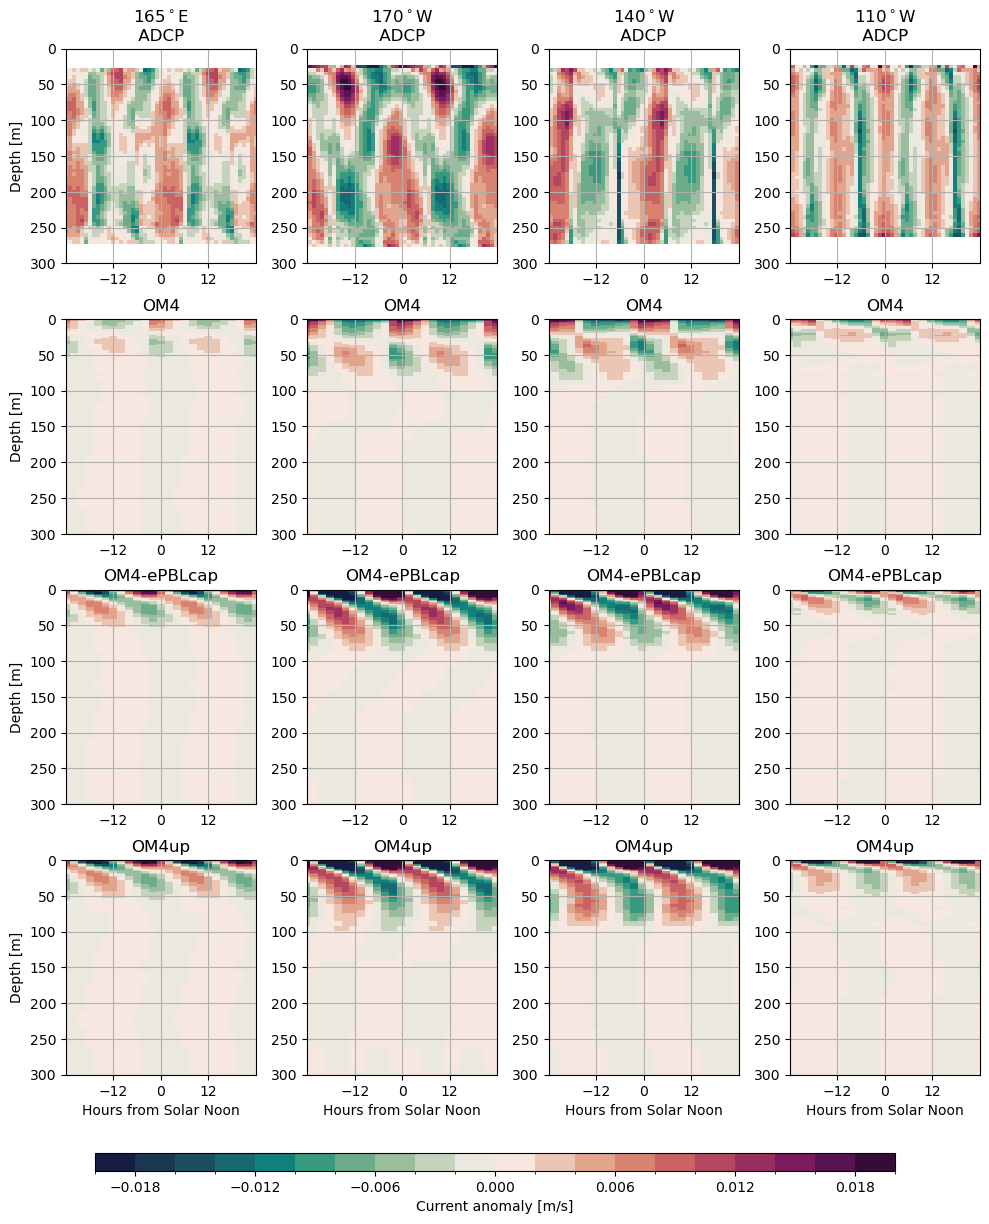

In [6]:
fig,AX=plt.subplots(4,4,figsize=(10,12))
cmap = copy.copy(cmocean.cm.curl)
#levels=[-1e-1,-5.e-2,-2.e-2,-1.e-2,-5.e-3,-2.e-3,-1.e-3,-5.e-4,-2.e-4,-1e-4,-5.e-5,-2.e-5,-1.e-5,
#        1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
levels=[-1e-1,-5.e-2,-2.e-2,-1.e-2,-5.e-3,-2.e-3,-1.e-3,-5.e-4,
        5.e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
levels = np.linspace(-0.02,0.02,21)
#levels = np.linspace(-2,2,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'
    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2011/01/01','2019/12/31')).isel(lat=0,lon=0)
    U= Hobs.u_1205.round(decimals=1).values.squeeze().astype(np.float64)/100.
    Uchk = ((Hobs.QU_5205.values.squeeze().T)[:,:]!=1)&((Hobs.QU_5205.values.squeeze().T)[:,:]!=2) 
    U[Uchk.T]=np.NaN
    
    Z=Hobs.depth.values.astype(np.float64)
    dU=np.gradient(U,Z,axis=1)**2
    dU[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    U[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    
    a=AX.ravel()[i]
    FLDdt = group_detrended_hour2(U)
    FLDdt=FLDdt-np.mean(FLDdt,axis=0)
    #FLDdt = group_detrended_hour_max(U)
    
    time=np.arange(24)+dT
    time[time>12]-=24;time[time>12]-=24
    xi=np.argsort(time)
    
    fld=(FLDdt[xi,:]).T

    C1=a.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                    Z,
                    (np.concatenate((fld,fld,fld),axis=1)),
                    cmap=cmap,
                    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    a.set_xlim(-24,24)
    a.set_ylim(300,0)
    a.set_xticks([-12,0,12])
    a.grid(True)
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')
    if i==0:
        a.set_ylabel('Depth [m]')
    
    for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up',]):
        
        
        Um=Model['U_'+LBL+'_'+Lon].values
        Zm=Model['Z_'+LBL+'_'+Lon].values
        CT = Model['Time_'+LBL+'_'+Lon].values
    
        LZ = len(Zm)
        LT = len(CT)
        ND = LT//12
        
        DD = np.reshape(Um.ravel(),(LZ,12,ND),order="F")
        U_dc = np.mean(DD,axis=2)
        U_dc = (U_dc.T - np.mean(U_dc,axis=1)).T
        #U_dc = np.max(DD,axis=2)
        
        time=np.arange(0,24,2)+(dT+1)
        time[time>12]-=24;time[time>12]-=24
        xi=np.argsort(time)
    
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),Zm,
                      np.concatenate((U_dc[:,xi],U_dc[:,xi],U_dc[:,xi]),axis=1),
               cmap=cmap,
               norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                     )
        ax.set_xlim(-24,24)
        ax.set_ylim(300,0)
        ax.set_xticks([-12,0,12])
        ax.grid(True)
        if i==0:
            ax.set_ylabel('Depth [m]')
        ax.set_title(LBL)
    ax.set_xlabel('Hours from Solar Noon')
        
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)



cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Current anomaly [m/s]')
# cb.ax.set(yticks=cb.get_ticks(),yticklabels=lbls)
#cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])        

<>:45: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/4117268756.py:45: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')


165.0 23.0
190.0 24.666666666666664
220.0 26.666666666666664
250.0 28.666666666666668


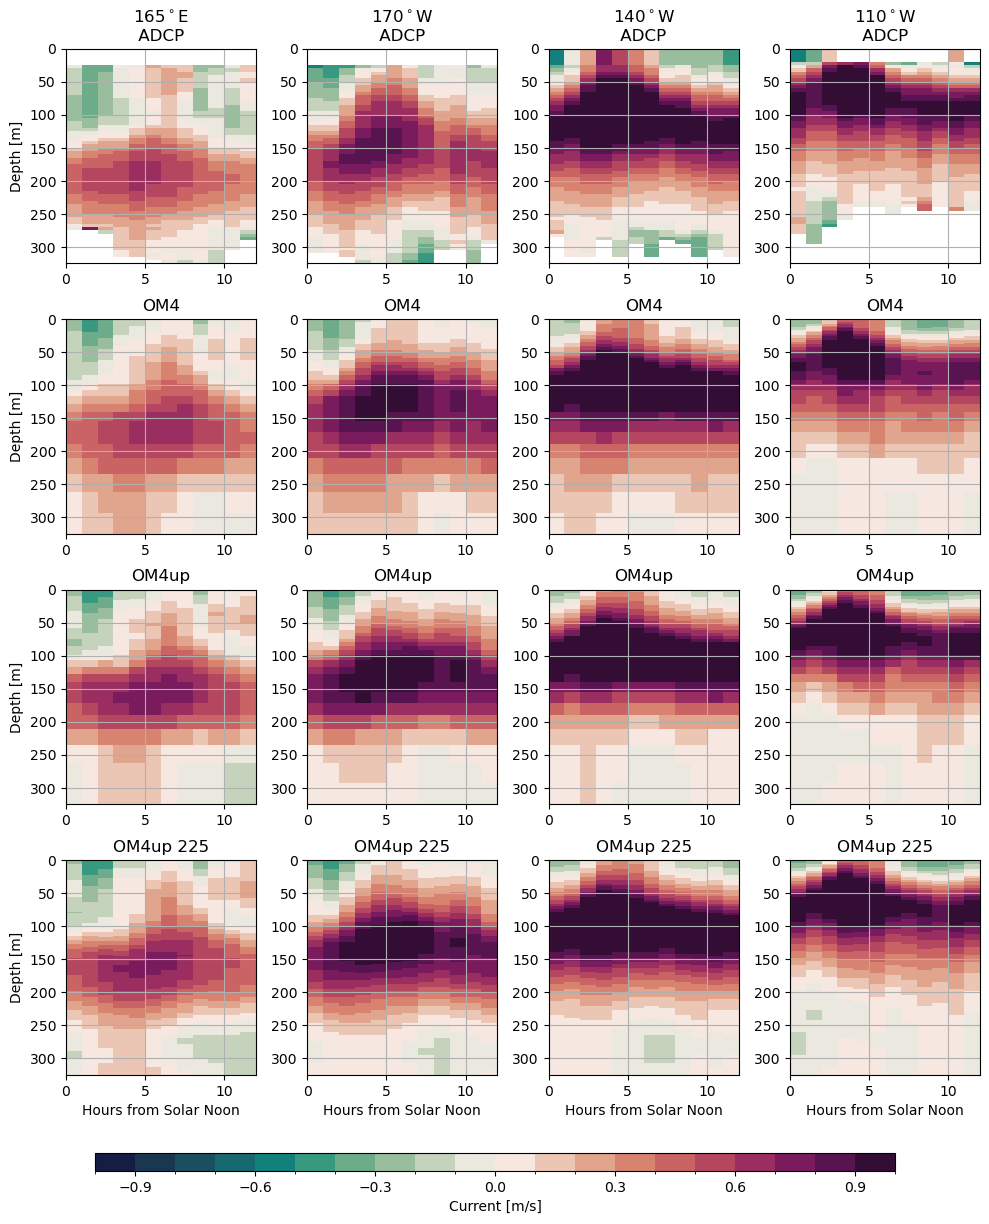

In [7]:
fig,AX=plt.subplots(4,4,figsize=(10,12))
cmap = copy.copy(cmocean.cm.curl)
#levels=[-1e-1,-5.e-2,-2.e-2,-1.e-2,-5.e-3,-2.e-3,-1.e-3,-5.e-4,-2.e-4,-1e-4,-5.e-5,-2.e-5,-1.e-5,
#        1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
levels=[-1e-1,-5.e-2,-2.e-2,-1.e-2,-5.e-3,-2.e-3,-1.e-3,-5.e-4,
        5.e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
levels = np.linspace(-0.02,0.02,21)
levels = np.linspace(-1,1,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'
    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    Hobs = Hobs.where(((Hobs.QU_5205.values.squeeze())[:,:]==1)|((Hobs.QU_5205.values.squeeze())[:,:]==2)).groupby("time.month").mean('time',skipna=True)
    U= Hobs.u_1205.round(decimals=1).values.squeeze().astype(np.float64)/100.
    
    Z=Hobs.depth.values.astype(np.float64)
    dU=np.gradient(U,Z,axis=1)**2
    # dU[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    # U[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    
    a=AX.ravel()[i]
    FLDdt=U#-np.mean(U,axis=0)
    #FLDdt = group_detrended_hour_max(U)
    
    time=np.arange(13)
    
    fld=(FLDdt).T

    C1=a.pcolormesh(time,
                    [0.,]+list(Z),
                    fld,
                    cmap=cmap,
                    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    a.set_xlim(0,12)
    a.set_ylim(325,0)
    a.grid(True)
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')
    if i==0:
        a.set_ylabel('Depth [m]')
    
    #for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up','OM4up 225',]):
    for li,LBL in enumerate(['OM4','OM4up','OM4up 225',]):

        A = xr.Dataset()
        A['time']=(('time'),Model['Time_'+LBL+'_'+Lon].values)
        A['z']=(('z'),Model['Z_'+LBL+'_'+Lon].values)
        A['U'] = (('time','z'),Model['U_'+LBL+'_'+Lon].values)
        Um=np.copy(A.groupby("time.month").mean('time',skipna=True).U.values).T
        Zm=Model['Zi_'+LBL+'_'+Lon].values
        
        
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(time,Zm,Um,
               cmap=cmap,
               norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                     )
        ax.set_xlim(0,12)
        ax.set_ylim(325,0)
        #ax.set_xticks([-12,0,12])
        ax.grid(True)
        if i==0:
            ax.set_ylabel('Depth [m]')
        ax.set_title(LBL)
    ax.set_xlabel('Hours from Solar Noon')
        
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)



cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Current [m/s]')
# cb.ax.set(yticks=cb.get_ticks(),yticklabels=lbls)
#cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])        

<>:55: SyntaxWarning: invalid escape sequence '\c'
<>:55: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/4032844184.py:55: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')


165.0 23.0


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


190.0 24.666666666666664


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


220.0 26.666666666666664


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


250.0 28.666666666666668


/tmp/ipykernel_1327350/1063629797.py:16: RuntimeWarning: Mean of empty slice
  FLD[ii,:]=np.nanmean(HRs,axis=0)


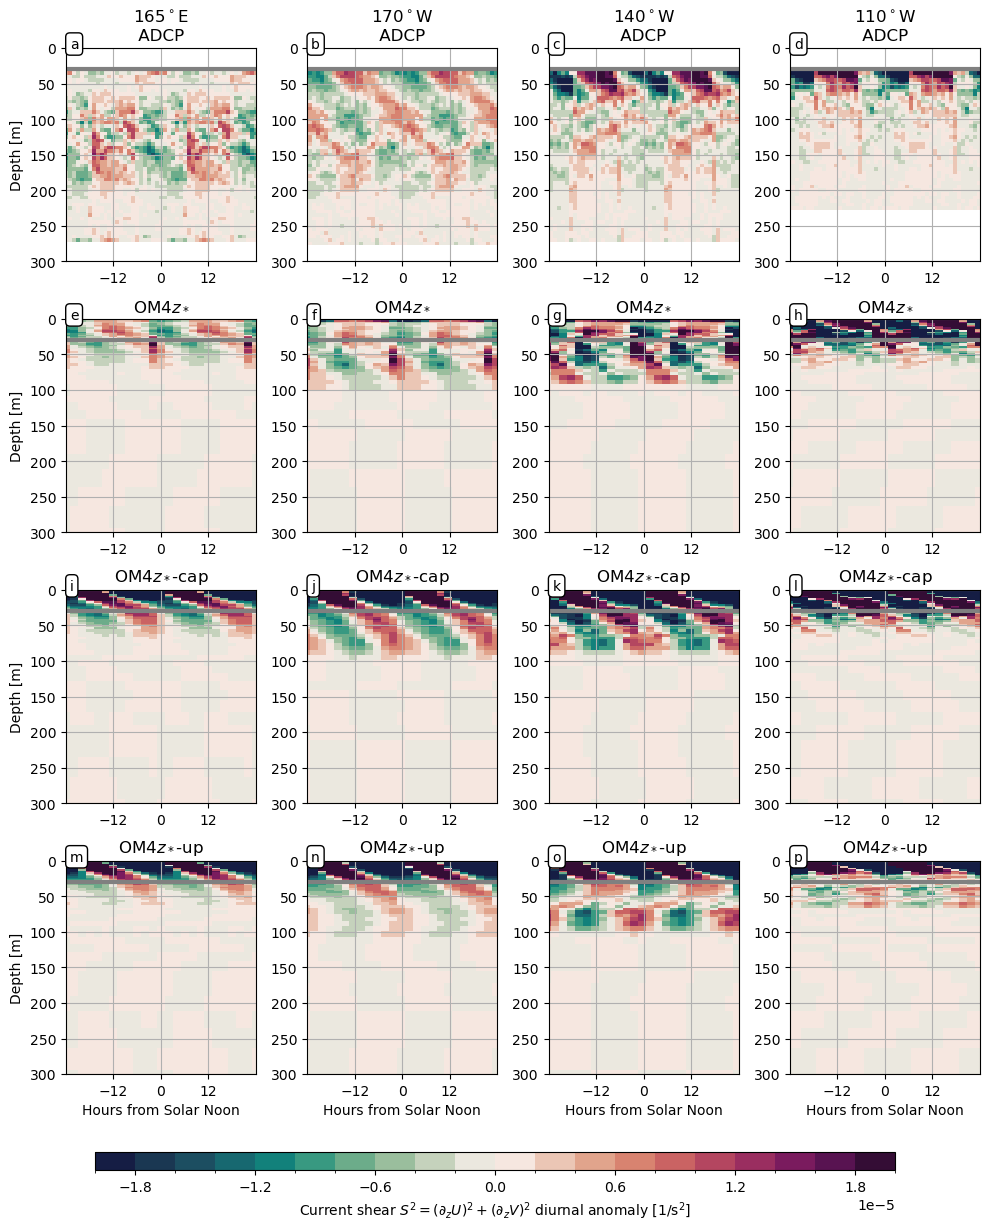

In [16]:
fig,AX=plt.subplots(4,4,figsize=(10,12))

cmap2 = copy.copy(cmocean.cm.curl)
levels2=[-1e-4,-5.e-5,-2.e-5,-1.e-5,-5.e-6,-2.e-6,-1.e-6,-5.e-7,
        5e-7,1.e-6,2e-6,5e-6,1e-5,2e-5,5e-5,1e-4]
levels2=np.linspace(-2.e-5,2.e-5,21)
#levels2=np.linspace(0,1.e-3,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'
    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    DSu = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    U=  DSu.u_1205.round(decimals=1).values.squeeze().astype(np.float64)/100.
    V = DSu.v_1206.round(decimals=1).values.astype(np.float64).squeeze()/100.
    UVchk = ((((DSu.QU_5205.values.squeeze().T)[:,:]!=1)&((DSu.QU_5205.values.squeeze().T)[:,:]!=2))&
            (((DSu.QV_5206.values.squeeze().T)[:,:]!=1)&((DSu.QV_5206.values.squeeze().T)[:,:]!=2)))
    U[UVchk.T]=np.NaN
    V[UVchk.T]=np.NaN
    Z=DSu.depth.values.astype(np.float64)
    dU=np.gradient(U,Z,axis=1)**2
    dV=np.gradient(V,Z,axis=1)**2
    dU[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    dV[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    U[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    V[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN

    a=AX.ravel()[i]
    FLDdt = group_detrended_hour2(dU+dV)
    FLDdt=FLDdt-np.mean(FLDdt,axis=0)
    #FLDdt = group_detrended_hour_max(dU+dV)
    
    time=np.arange(24)+dT
    time[time>12]-=24;time[time>12]-=24
    xi=np.argsort(time)
    
    fld=(FLDdt[xi,:]).T

    C1=a.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                    Z,
                    (np.concatenate((fld,fld,fld),axis=1)),
                    cmap=cmap2,
                    norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False)
                   )
    a.set_xlim(-24,24)
    a.set_ylim(300,0)
    a.set_xticks([-12,0,12])
    a.grid(True)
    a.axhline(y=30,color='gray',linewidth=3)
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')
    if i==0:
        a.set_ylabel('Depth [m]')
    
    for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up',]):
    #for li,LBL in enumerate(['OM4','OM4up','OM4up 225',]):
        if LBL=='OM4':
            TTL='OM4$z_*$'
        elif LBL=='OM4-ePBLcap':
            TTL='OM4$z_*$-cap'
        elif LBL=='OM4up':
            TTL='OM4$z_*$-up'
        
        Um=Model['U_'+LBL+'_'+Lon].values
        Sx=Model['Sx_'+LBL+'_'+Lon].values
        Sy=Model['Sy_'+LBL+'_'+Lon].values
        N2=Model['N2_'+LBL+'_'+Lon].values
        Zm=Model['Z_'+LBL+'_'+Lon].values
        CT = Model['Time_'+LBL+'_'+Lon].values
    
        LZ = len(Zm)
        LT = len(CT)
        ND = LT//12
        
        DD = np.reshape(Sx.ravel()+Sy.ravel(),(LZ,12,ND),order="F")
        S2_dc = np.mean(DD,axis=2)
        S2_dc = (S2_dc.T - np.mean(S2_dc,axis=1)).T
        #S2_dc = np.percentile(DD,96,axis=2)
        
        
        time=np.arange(0,24,2)+(dT+1)
        time[time>12]-=24;time[time>12]-=24
        xi=np.argsort(time)
    
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),Zm,
                      np.concatenate((S2_dc[:,xi],S2_dc[:,xi],S2_dc[:,xi]),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False)
                     )
        ax.set_xlim(-24,24)
        ax.set_ylim(300,0)
        ax.set_xticks([-12,0,12])
        ax.grid(True)
        ax.set_title(TTL)
        ax.axhline(y=30,color='gray',linewidth=3)
        if i==0:
            ax.set_ylabel('Depth [m]')        
    ax.set_xlabel('Hours from Solar Noon')
        
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)


for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-23,0,txt,bbox=dict(boxstyle='round', facecolor='white'))

cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Current shear $S^2=(\partial_z U)^2 + (\partial_z V)^2$ diurnal anomaly [1/s$^2$]')
# cb.ax.set(yticks=cb.get_ticks(),yticklabels=lbls)
#cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])             

fig.savefig('../Fig/TAO_OM4_DiurnalShearAnomaly.png',dpi=200,bbox_inches = "tight")


<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/302633907.py:40: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')


165.0 23.0
190.0 24.666666666666664
220.0 26.666666666666664
250.0 28.666666666666668


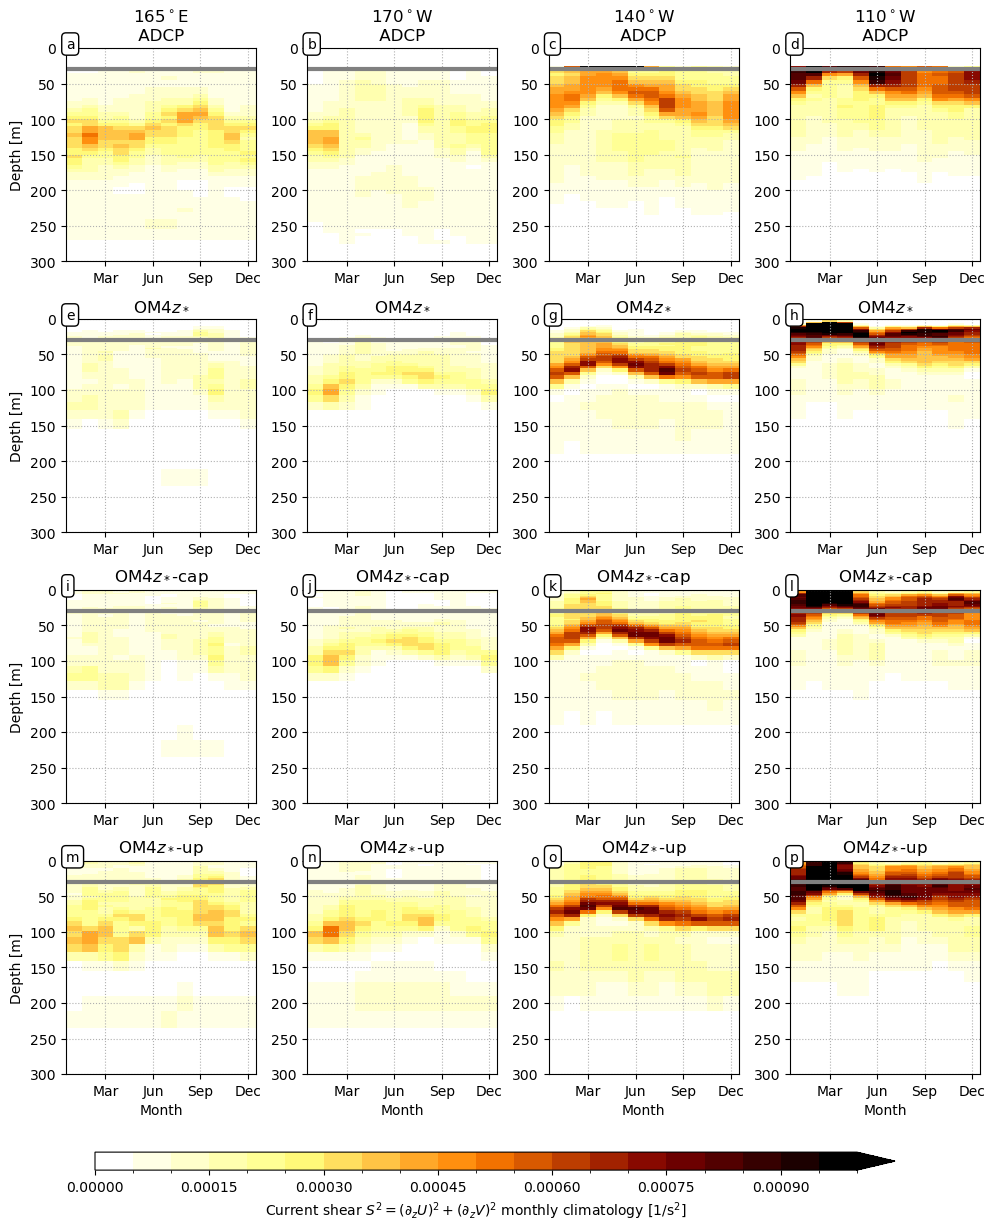

In [18]:
fig,AX=plt.subplots(4,4,figsize=(10,12))
cmap = copy.copy(mpl.cm.afmhot_r)
levels = np.linspace(0,1e-3,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'
    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    dU = (((Hobs.u_1205.round(decimals=1).astype(np.float64)/100.).where(((Hobs.QU_5205.values.squeeze())[:,:]==1)|((Hobs.QU_5205.values.squeeze())[:,:]==2)).differentiate(coord='depth'))**2).groupby("time.month").mean('time',skipna=True).values.squeeze()
    dV = (((Hobs.v_1206.round(decimals=1).astype(np.float64)/100.).where(((Hobs.QV_5206.values.squeeze())[:,:]==1)|((Hobs.QV_5206.values.squeeze())[:,:]==2)).differentiate(coord='depth'))**2).groupby("time.month").mean('time',skipna=True).values.squeeze()
    U= Hobs.u_1205.round(decimals=1).values.squeeze().astype(np.float64)/100.
    Uchk = ((Hobs.QU_5205.values.squeeze().T)[:,:]!=1)&((Hobs.QU_5205.values.squeeze().T)[:,:]!=2) 
    U[Uchk.T]=np.NaN
    dU[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    dV[:,np.sum(np.isfinite(U),axis=0)<=24*365*2]=np.NaN
    Z = Hobs.depth.values
    a=AX.ravel()[i]
    FLDdt=dU+dV#-np.mean(U,axis=0)
    #FLDdt = group_detrended_hour_max(U)
    
    time=np.arange(13)
    
    fld=(FLDdt).T

    C1=a.pcolormesh(time,
                    [0.,]+list(Z),
                    fld,
                    cmap=cmap,
                    norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    a.set_xlim(0,12)
    a.set_ylim(300,0)
    a.grid(True,linestyle=':')
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n ADCP ')
    if i==0:
        a.set_ylabel('Depth [m]')
    a.axhline(y=30,color='gray',linewidth=3)
    
    for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up']):
    #for li,LBL in enumerate(['OM4','OM4up','OM4up 225',]):

        A = xr.Dataset()
        A['time']=(('time'),Model['Time_'+LBL+'_'+Lon].values)
        A['z']=(('z'),Model['Z_'+LBL+'_'+Lon].values)
        A['dU'] = (('time','z'),Model['Sx_'+LBL+'_'+Lon].values+Model['Sy_'+LBL+'_'+Lon].values)
        Um=np.copy(A.groupby("time.month").mean('time',skipna=True).dU.values).T
        Zm=Model['Zi_'+LBL+'_'+Lon].values
        if LBL=='OM4':
            TTL='OM4$z_*$'
        elif LBL=='OM4-ePBLcap':
            TTL='OM4$z_*$-cap'
        elif LBL=='OM4up':
            TTL='OM4$z_*$-up'
        
        
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(time,Zm,Um,
               cmap=cmap,
               norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                     )
        ax.set_xlim(0,12)
        ax.set_ylim(300,0)
        #ax.set_xticks([-12,0,12])
        ax.grid(True,linestyle=':')
        if i==0:
            ax.set_ylabel('Depth [m]')
        ax.set_title(TTL)
        ax.axhline(y=30,color='gray',linewidth=3)
    ax.set_xlabel('Month')
    
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)


for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(0,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
    AX.ravel()[AXi].set_xticks([2.5,5.5,8.5,11.5])
    AX.ravel()[AXi].set_xticklabels(['Mar','Jun','Sep','Dec'])

cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal',extend='max')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Current shear $S^2=(\partial_z U)^2 + (\partial_z V)^2$ monthly climatology [1/s$^2$]')
# cb.ax.set(yticks=cb.get_ticks(),yticklabels=lbls)
#cb.ax.set_xticks(ticks=[-5,-2.5,0,2.5,5])             

fig.savefig('../Fig/TAO_OM4_Monthly_Shear.png',dpi=200,bbox_inches = "tight")     

<>:83: SyntaxWarning: invalid escape sequence '\c'
<>:83: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/660854297.py:83: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n TAO ')


165.0 23.0
190.0 24.666666666666664                                                                                                       
220.0 26.666666666666664                                                                                                       
250.0 28.666666666666668                                                                                                       


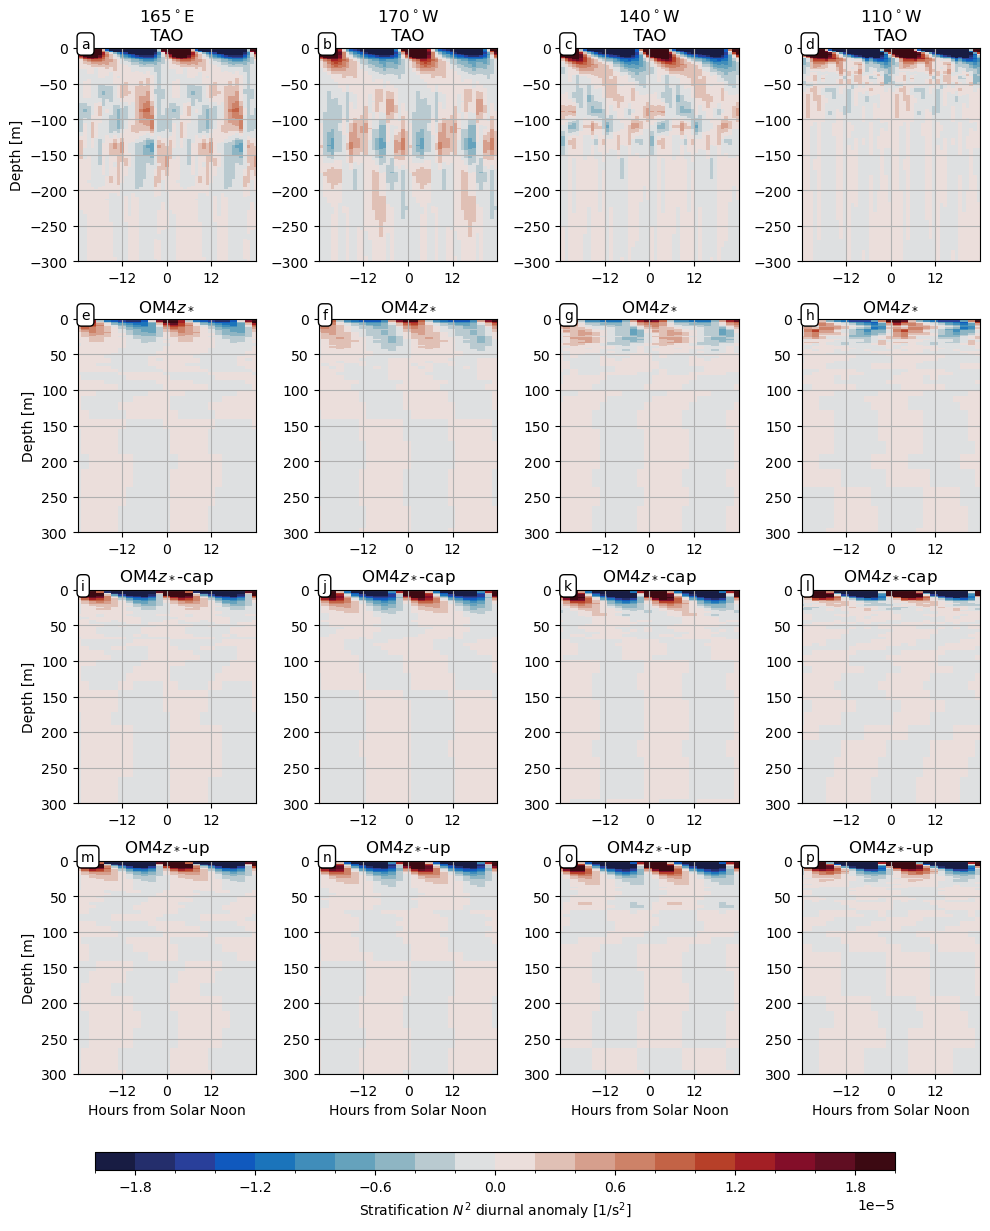

In [10]:
fig,AX=plt.subplots(4,4,figsize=(10,12))
Zinterp=np.arange(1,300,2)
cmap2 = copy.copy(cmocean.cm.balance)
# levels2=[-1e-4,-5.e-5,-2.e-5,-1.e-5,-5.e-6,-2.e-6,
#         2e-6,5e-6,1e-5,2e-5,5e-5,1e-4]
# levels2=[-1e-4,-5.e-5,-2.e-5,-1.e-5,-5.e-6,-2.e-6,-1.e-6,-5.e-7,
#         5e-7,1.e-6,2e-6,5e-6,1e-5,2e-5,5e-5,1e-4]
levels2=np.linspace(-2.e-5,2.e-5,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    T_file='/net2/bgr/Data/Mooring/TAO/HiRes/t0n'+Lon+'_10m.cdf_1h'
    S_file='/net2/bgr/Data/Mooring/TAO/HiRes/s0n'+Lon+'_hr.cdf'
    DSt= xr.open_dataset(T_file).sel(time=slice('01/01/2015','12/31/2021')).isel(lat=0,lon=0)
    DSs= xr.open_dataset(S_file).sel(time=slice('01/01/2015','12/31/2021')).isel(lat=0,lon=0)

    LT = DSt.time.size
    Tg = DSt.T_20.round(decimals=5).squeeze().values.astype(np.float64)
    Sg = DSs.S_41.round(decimals=3).squeeze().values.astype(np.float64)
    N2_tao_ST = np.zeros([LT,len(Zinterp)])+np.NaN
    N2_tao_T = np.zeros([LT,len(Zinterp)])+np.NaN
    Rho_tao_T = np.zeros([LT,len(Zinterp)])+np.NaN
    Rho_tao_ST = np.zeros([LT,len(Zinterp)])+np.NaN
    
    for TI in range(DSt.time.size):
        print(Lon+' '+str(TI/DSt.time.size)+' '*100,end='\r')
        Zchk = ((DSt.QT_5020.values.squeeze().T)[:,TI]==1)|((DSt.QT_5020.values.squeeze().T)[:,TI]==2)
        ZchkS = ((DSs.QS_5041.values.squeeze().T)[:,TI]==1)|((DSs.QS_5041.values.squeeze().T)[:,TI]==2)
        Z = (DSt.depth.values[Zchk])
        ZS = (DSs.depth.values[ZchkS])
        if (len(Z)>1):
            DZ = Z[1:]-Z[:-1]
            Zc = 0.5*(Z[1:]+Z[:-1])
            if ((len(Z)>5) and (min(Zc)<10.) and (max(Zc)>=100)):
                #if ( (np.max(DZ[Zc<25])<=15) and (np.max(DZ[Zc<100])<=25)):
                if ( (np.max(DZ[Zc<50])<=50) and (np.max(DZ[Zc<100])<=50)):
                    T = Tg[TI,Zchk]
                    P = gsw.p_from_z(-Z,0)
                    cT = gsw.CT_from_t(35,T,P)
                    prho = gsw.sigma0(35,cT)
                    dsigma = prho[:-1]-prho[1:]
                    N2_ = -9.81/1025*dsigma/DZ
                    N2_tao_T[TI,:] = np.interp(Zinterp,Zc,N2_)
                    Rho_tao_T[TI,:] = np.interp(Zinterp,Z,prho)
                    
                    if len(ZS)>1:
                        S = Sg[TI,ZchkS]
                        S = np.interp(Z,ZS,S)
                        P = gsw.p_from_z(-Z,0)
                        SA = gsw.SA_from_SP(S,P,lon,0)
                        cT = gsw.CT_from_t(SA,T,P)
                        prho = gsw.sigma0(SA,cT)
                        dsigma = prho[:-1]-prho[1:]
                        N2_ = -9.81/1025*dsigma/DZ
                        N2_tao_ST[TI,:] = np.interp(Zinterp,Zc,N2_)
                        Rho_tao_ST[TI,:] = np.interp(Zinterp,Z,prho)
                        

    a=AX.ravel()[i]
    FLDdt = group_detrended_hour2(N2_tao_ST)
    FLDdt=FLDdt-np.mean(FLDdt,axis=0)
    time=np.arange(24)+dT
    time[time>12]-=24;time[time>12]-=24
    xi=np.argsort(time)
    
    fld=(FLDdt[xi,:]).T

    C1=a.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),
                    -Zinterp,
                    (np.concatenate((fld,fld,fld),axis=1)),
                    cmap=cmap2,
                    norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False)
                   )
    a.set_xlim(-24,24)
    a.set_ylim(-300,0)
    a.set_xticks([-12,0,12])
    a.grid(True)
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n TAO ')
    if i==0:
        a.set_ylabel('Depth [m]')
    
    for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up',]):
        
        
        N2=Model['N2_'+LBL+'_'+Lon].values
        Zm=Model['Z_'+LBL+'_'+Lon].values
        
        CT = Model['Time_'+LBL+'_'+Lon].values
    
        LZ = len(Zm)
        LT = len(CT)
        ND = LT//12
        
        DD = np.reshape(N2.ravel(),(LZ,12,ND),order="F")
        N2_dc = np.mean(DD,axis=2)
        N2_dc = (N2_dc.T - np.mean(N2_dc,axis=1)).T
        if LBL=='OM4':
            TTL='OM4$z_*$'
        elif LBL=='OM4-ePBLcap':
            TTL='OM4$z_*$-cap'
        elif LBL=='OM4up':
            TTL='OM4$z_*$-up'
        
        time=np.arange(0,24,2)+(dT+1)
        time[time>12]-=24;time[time>12]-=24
        xi=np.argsort(time)
    
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(np.concatenate((time[xi]-24.,time[xi],time[xi]+24)),Zm,
                      np.concatenate((N2_dc[:,xi],N2_dc[:,xi],N2_dc[:,xi]),axis=1),
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap.N, clip=False)
                     )
        ax.set_xlim(-24,24)
        ax.set_ylim(300,0)
        ax.set_xticks([-12,0,12])
        ax.grid(True)
        if i==0:
            ax.set_ylabel('Depth [m]')
        ax.set_title(TTL)
    ax.set_xlabel('Hours from Solar Noon')
        
    
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)



for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-23,0,txt,bbox=dict(boxstyle='round', facecolor='white'))

cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal')
#lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Stratification $N^2$ diurnal anomaly [1/s$^2$]')

fig.savefig('../Fig/TAO_OM4_DiurnalN2Anomaly.png',dpi=200,bbox_inches = "tight")  

<>:80: SyntaxWarning: invalid escape sequence '\c'
<>:80: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1327350/2247650498.py:80: SyntaxWarning: invalid escape sequence '\c'
  a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n TAO ')


165.0 23.0
190.0 24.666666666666664                                                                                                       
220.0 26.666666666666664                                                                                                       
250.0 28.666666666666668                                                                                                       


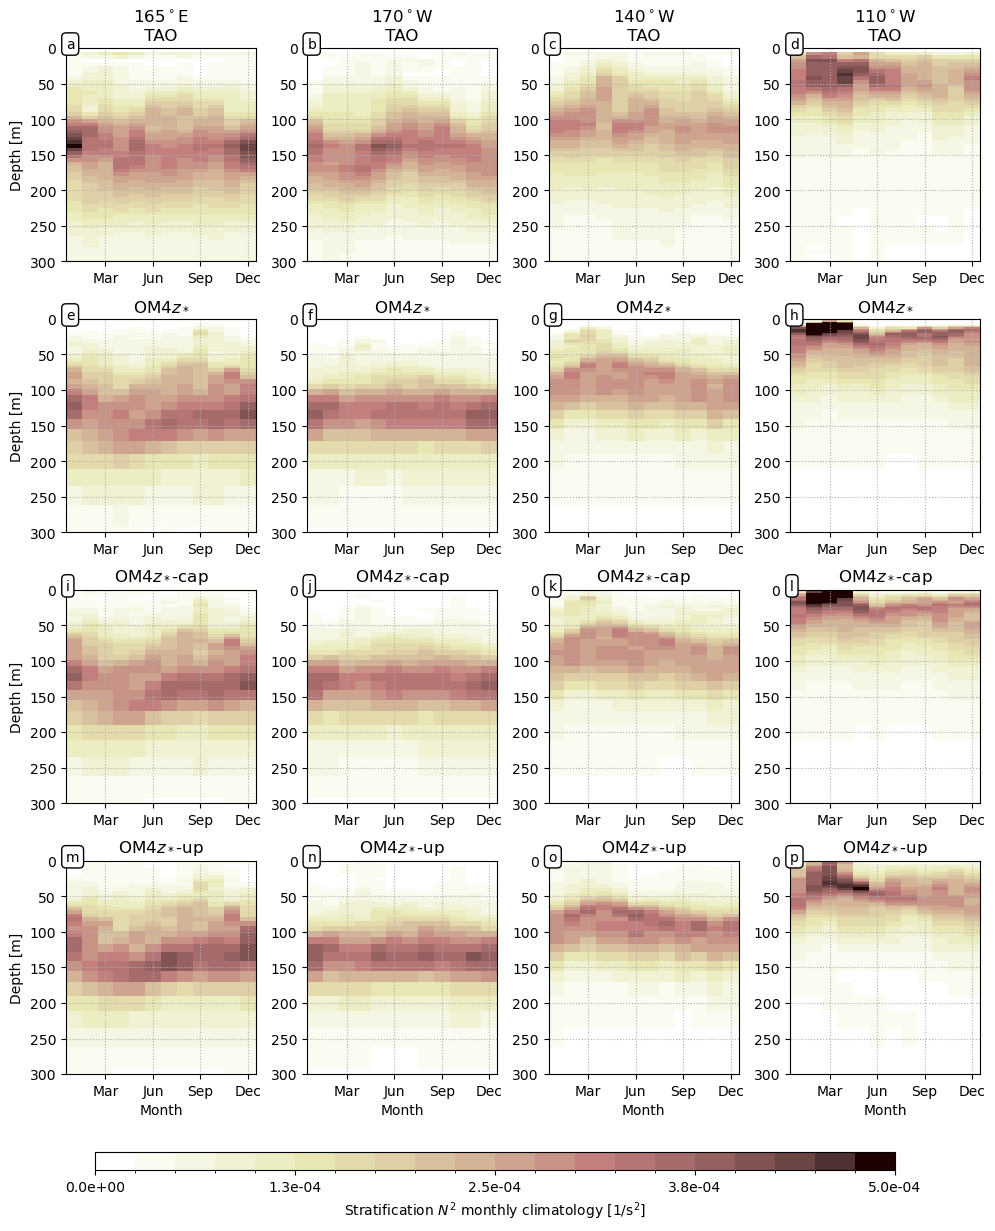

In [11]:
fig,AX=plt.subplots(4,4,figsize=(10,12))
Zinterp=np.arange(2.5,300,5)
Ziinterp=np.arange(0,302.5,5)
cmap2 = copy.copy(mpl.cm.pink_r)
levels2=[-1e-1,-5.e-2,-2.e-2,-1.e-2,-5.e-3,-2.e-3,
        2e-3,5e-3,1e-2,2e-2,5e-2,1e-1]
levels2=np.linspace(0,5.e-4,21)


for i,Lon in enumerate(['165e','170w','140w','110w']):
    lon = float(Lon[:3])
    if Lon[3]=='w':
        lon=360-lon
    dT = lon/15+12
    print(lon,dT)
    #This block was used to create U utilized below
    T_file='/net2/bgr/Data/Mooring/TAO/HiRes/t0n'+Lon+'_10m.cdf_1h'
    S_file='/net2/bgr/Data/Mooring/TAO/HiRes/s0n'+Lon+'_hr.cdf'
    DSt= xr.open_dataset(T_file).sel(time=slice('01/01/2015','12/31/2021')).isel(lat=0,lon=0)
    DSs= xr.open_dataset(S_file).sel(time=slice('01/01/2015','12/31/2021')).isel(lat=0,lon=0)

    LT = DSt.time.size
    Tg = DSt.T_20.round(decimals=5).squeeze().values.astype(np.float64)
    Sg = DSs.S_41.round(decimals=3).squeeze().values.astype(np.float64)
    N2_tao_ST = np.zeros([LT,len(Zinterp)])+np.NaN
    N2_tao_T = np.zeros([LT,len(Zinterp)])+np.NaN
    Rho_tao_T = np.zeros([LT,len(Zinterp)])+np.NaN
    Rho_tao_ST = np.zeros([LT,len(Zinterp)])+np.NaN
    
    for TI in range(DSt.time.size):
        print(Lon+' '+str(TI/DSt.time.size)+' '*100,end='\r')
        Zchk = ((DSt.QT_5020.values.squeeze().T)[:,TI]==1)|((DSt.QT_5020.values.squeeze().T)[:,TI]==2)
        ZchkS = ((DSs.QS_5041.values.squeeze().T)[:,TI]==1)|((DSs.QS_5041.values.squeeze().T)[:,TI]==2)
        Z = (DSt.depth.values[Zchk])
        ZS = (DSs.depth.values[ZchkS])
        if (len(Z)>1):
            DZ = Z[1:]-Z[:-1]
            Zc = 0.5*(Z[1:]+Z[:-1])
            if ((len(Z)>5) and (min(Zc)<10.) and (max(Zc)>=100)):
                #if ( (np.max(DZ[Zc<25])<=15) and (np.max(DZ[Zc<100])<=25)):
                if ( (np.max(DZ[Zc<50])<=50) and (np.max(DZ[Zc<100])<=50)):
                    T = Tg[TI,Zchk]
                    P = gsw.p_from_z(-Z,0)
                    cT = gsw.CT_from_t(35,T,P)
                    prho = gsw.sigma0(35,cT)
                    dsigma = prho[:-1]-prho[1:]
                    N2_ = -9.81/1025*dsigma/DZ
                    N2_tao_T[TI,:] = np.interp(Zinterp,Zc,N2_)
                    Rho_tao_T[TI,:] = np.interp(Zinterp,Z,prho)
                    
                    if len(ZS)>1:
                        S = Sg[TI,ZchkS]
                        S = np.interp(Z,ZS,S)
                        P = gsw.p_from_z(-Z,0)
                        SA = gsw.SA_from_SP(S,P,lon,0)
                        cT = gsw.CT_from_t(SA,T,P)
                        prho = gsw.sigma0(SA,cT)
                        dsigma = prho[:-1]-prho[1:]
                        N2_ = -9.81/1025*dsigma/DZ
                        N2_tao_ST[TI,:] = np.interp(Zinterp,Zc,N2_,left=np.NaN,right=np.NaN)
                        Rho_tao_ST[TI,:] = np.interp(Zinterp,Z,prho,left=np.NaN,right=np.NaN)
                        
    
    a=AX.ravel()[i]
    A = xr.Dataset()
    A['time']=(('time'),DSt.time.values)
    A['z']=(('z'),Zinterp)
    A['data'] = (('time','z'),N2_tao_ST)
    N2=np.copy(A.groupby("time.month").mean('time',skipna=True).data.values).T
    
    time=np.arange(13)
    C1=a.pcolormesh(time,Ziinterp,N2,
                    cmap=cmap2,
                    norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
                   )
    a.set_xlim(0,12)
    a.set_ylim(300,0)
    #a.set_xticks([-12,0,12])
    a.grid(True,linestyle=':')
    a.set_title(Lon[:-1]+'$^\circ$'+Lon[-1].upper()+'\n TAO ')
    if i==0:
        a.set_ylabel('Depth [m]')
    
    for li,LBL in enumerate(['OM4','OM4-ePBLcap','OM4up',]):
        
        if LBL=='OM4':
            TTL='OM4$z_*$'
        elif LBL=='OM4-ePBLcap':
            TTL='OM4$z_*$-cap'
        elif LBL=='OM4up':
            TTL='OM4$z_*$-up'
        
        Rho=Model['Rho0_'+LBL+'_'+Lon].values
        Zm=Model['Zi_'+LBL+'_'+Lon].values
        
        A = xr.Dataset()
        A['time']=(('time'),Model['Time_'+LBL+'_'+Lon].values)
        A['z']=(('z'),Model['Z_'+LBL+'_'+Lon].values)
        A['data'] = (('time','z'),Model['N2_'+LBL+'_'+Lon].values)
        N2=np.copy(A.groupby("time.month").mean('time',skipna=True).data.values).T
        
    
        ax=AX.ravel()[i+4*(li+1)]
        ax.pcolormesh(time,Zm,N2,
               cmap=cmap2,
               norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False)
                     )
        ax.set_xlim(-0,12)
        ax.set_ylim(300,0)
        #ax.set_xticks([-12,0,12])
        ax.grid(True,linestyle=':')
        if i==0:
            ax.set_ylabel('Depth [m]')
        ax.set_title(TTL)
    ax.set_xlabel('Month')
    
    
fig.tight_layout()

fig.subplots_adjust(bottom=0.1)



for AXi in range(16):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(0,0,txt,bbox=dict(boxstyle='round', facecolor='white'))
    AX.ravel()[AXi].set_xticks([2.5,5.5,8.5,11.5])
    AX.ravel()[AXi].set_xticklabels(['Mar','Jun','Sep','Dec'])

cbar_ax = fig.add_axes([0.1, 0.02, 0.8, 0.015])
cb=fig.colorbar(C1, cax=cbar_ax,orientation='horizontal')
cb.ax.set_xticks(ticks=[0,1.25e-4,2.5e-4,3.75e-4,5e-4])             
lbls = ["{:1.1e}".format(i) for i in cb.get_ticks()]
cb.set_label(r'Stratification $N^2$ monthly climatology [1/s$^2$]')
cb.ax.set(xticks=cb.get_ticks(),xticklabels=lbls)

fig.savefig('../Fig/TAO_OM4_Monthly_N2.png',dpi=200,bbox_inches = "tight")